In [613]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [614]:
#Pull in data
train = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')

Lets see what our possible features can be. Looks like some are would be really useful but others not so much like MiscFeature and LandSlope.

In [615]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Let's checkout what Sales Price is like.

In [616]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Looks like we aren't missing any data there so lets see what things tend to correlate with SalesPrice.

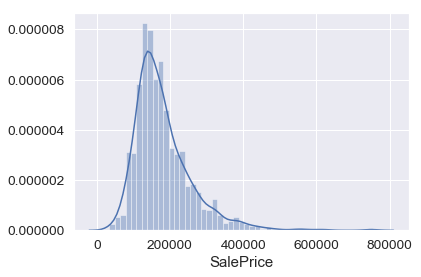

In [617]:
sns.distplot(train['SalePrice'])

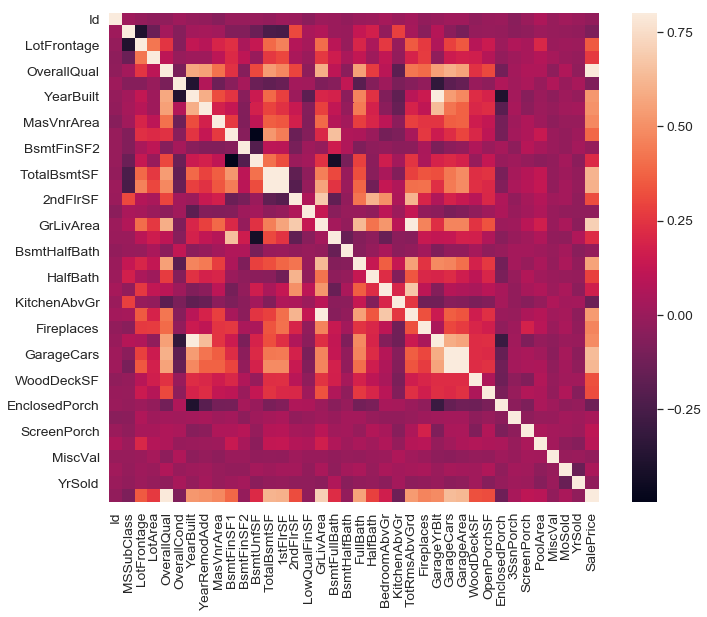

In [618]:
train.corr()

corrmat = train.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

It looks like there might be some heat for `SalePrice` with `OverallQuality`, `GrlivArea`, `GarageCars`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF`, `YearBuilt`. So lets zoom in on those to see what matter most.

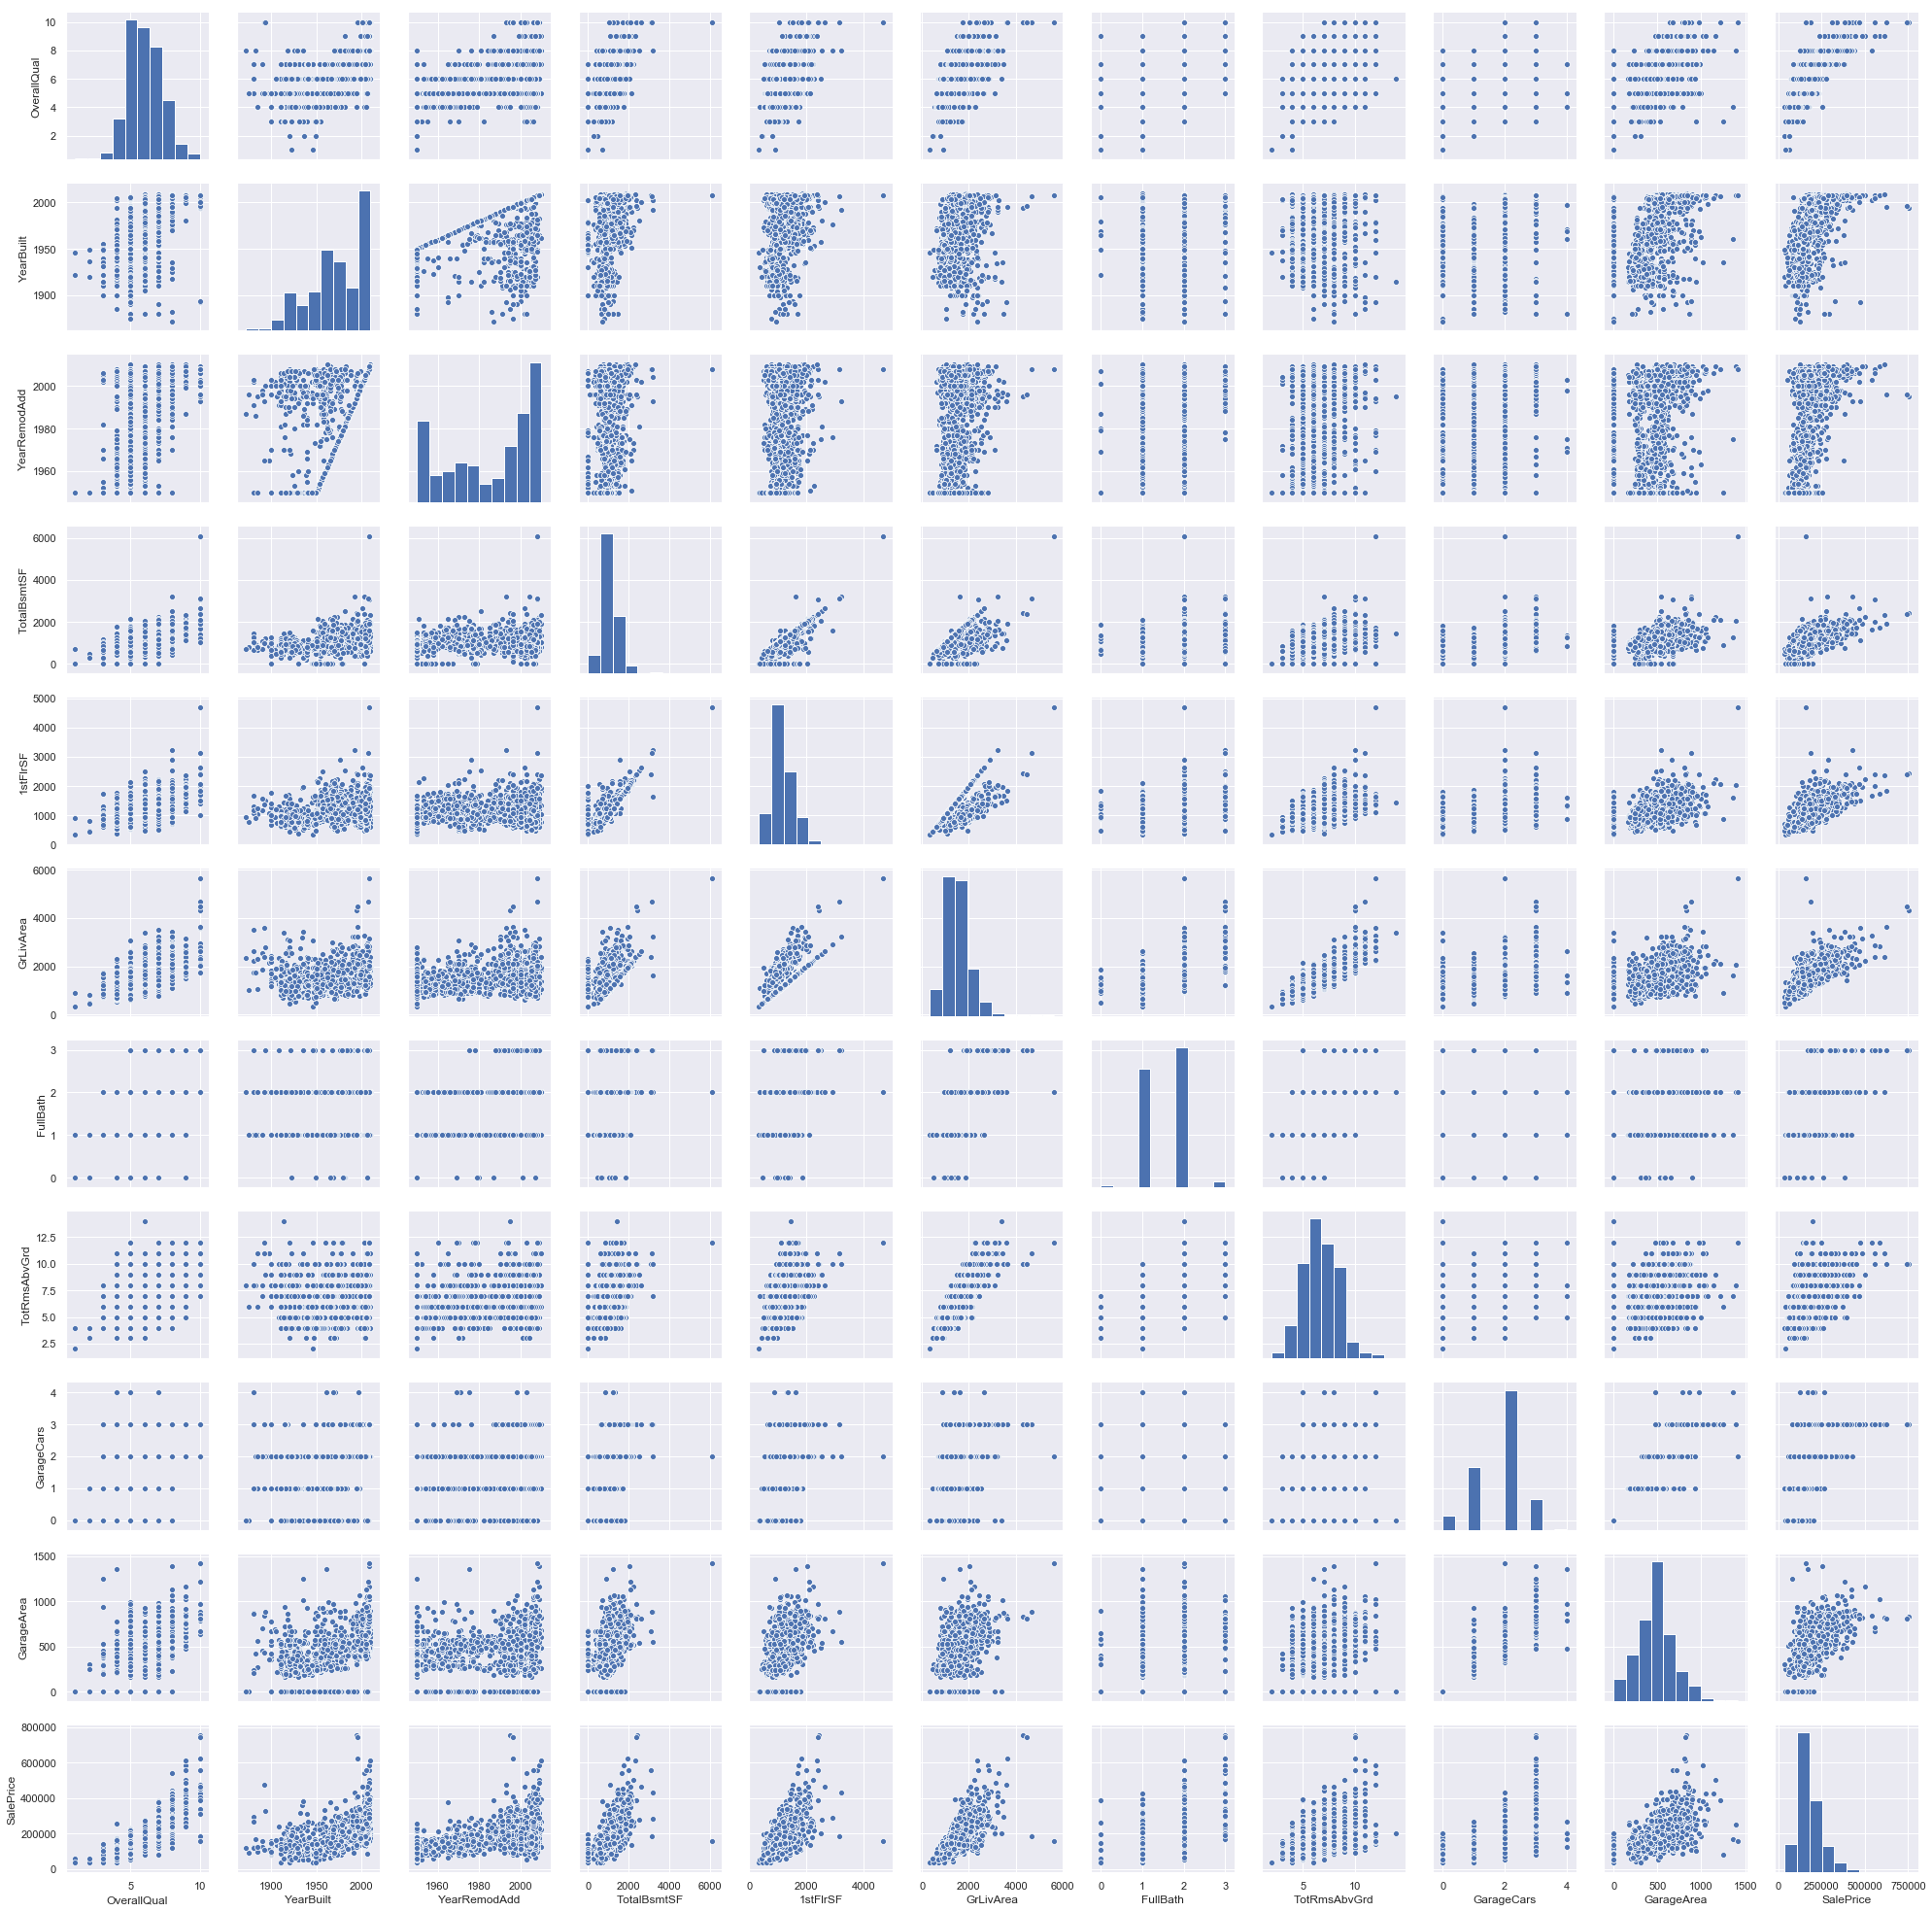

In [619]:
cols = [ 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
        '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice']
sns.set()
sns.pairplot(train[cols], size = 2.5)
plt.show()

Knowing these relationships helps us decide whether it would be useful to include ploynomial features to our LR model. It looks like potentially 5 variables could have this relationship so we should try it out will prove useful when deciding whether to include polynomial features but for now lets just see how linear regression does.

Lets see what our situation with missing data is

In [620]:
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum())/(train.isnull().count())).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(21)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


So after Electrical there are no more missing values so at least we don't need to worry about every single feature. Let start looking through the rest!
    PoolQC-LotFrontage are all missing large amounts of data such that we don't really have enough information to be able to do analysis based on those features so we'll just drop them.
    GarageX seem all have the same number of missing data which makes me believe that they are probably just houses without garages so those features wouldn't be missed since it won't help predict for houses without garages. I'd imagine that they are correlated with other garage variables that aren't missing.
    BsmtX seems like the same situation as the garage variables and those features can probably be captured in other basement variables that aren't missing
    MasVnrArea-Electrical these values are so few that I don't have an issue just dropping them.
Essentially we are going to drop them all.

In [621]:
train = train.drop((missing_data[missing_data['Total'] >= 1]).index, 1)
train.isnull().sum().max()

0

Now we need to analyze any outliers in our most valuable features, to do this we need to standardize the data so that we can set a boundary for what is an outlier and what isn't. If our outliers are following the general trends predictedd by our most valuable features then they will be more helpful if we keep them rather than dropping them

In [622]:
mean_of_array = train['SalePrice'].mean()
std_of_array = train['SalePrice'].std()
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
low_range

array([[-1.83870376],
       [-1.83352844],
       [-1.80092766],
       [-1.78329881],
       [-1.77448439],
       [-1.62337999],
       [-1.61708398],
       [-1.58560389],
       [-1.58560389],
       [-1.5731    ]])

In [623]:
high_range

array([[3.82897043],
       [4.04098249],
       [4.49634819],
       [4.71041276],
       [4.73032076],
       [5.06214602],
       [5.42383959],
       [5.59185509],
       [7.10289909],
       [7.22881942]])

Well the lower values don't look like they are outliers (probably because a sale price can't be negative) but some of the higher values are pretty up high so we'll have to keep an eye on those. Now lets looks at the bivarate relationship between SalePrice and the top correlators!

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


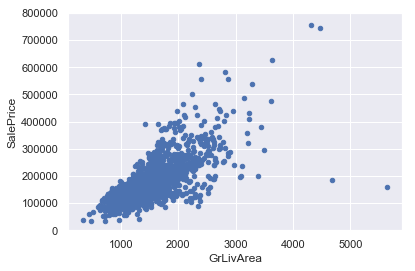

In [624]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

Our high SalePrice values look to follow the trend but those 2 large GrLivArea look like the don't so lets drop them

In [625]:
train.sort_values(by = var, ascending=False)[:2]
train = train.drop(train[train['Id'] == 1298].index)
train = train.drop(train[train['Id'] == 524].index)
len(train.columns)

62

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


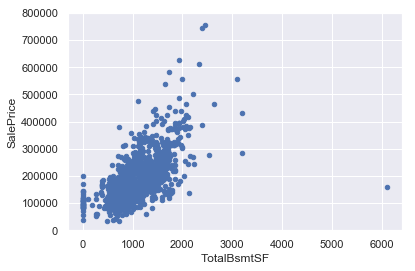

In [626]:
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

Our high SalePrice values look to follow the trend but that large TotalBsmtSF looks pretty out of place.

In [627]:
train.sort_values(by = var, ascending=False)[:1]
train = train.drop(train[train['Id'] == 1299].index)

Now we need to get dirtier with out data by looking into the normality of our variables, and seeing if they are linear in relation so that we can help our Linear Regression work well.

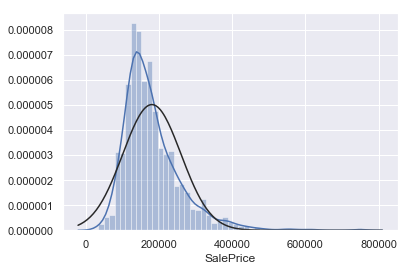

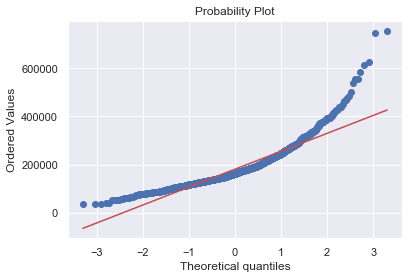

In [628]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

So Sale Price looks to be pretty off center in the positive direction and the second graph shows the distribution but in a probablity format, ideally it would follow the red line perfectly but obviously it doesn'tbut also not very linear. Lets see if a data transformation can help with that.

In [629]:
train['SalePrice'] = np.log(train['SalePrice'])

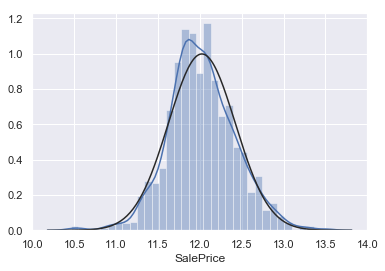

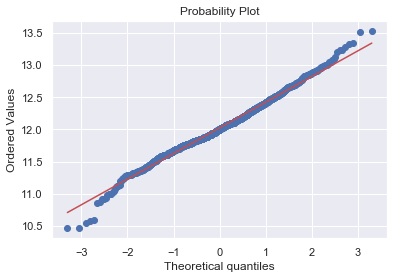

In [630]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

Awesome this looks great! Lets look at the other variables and see how they are doing.

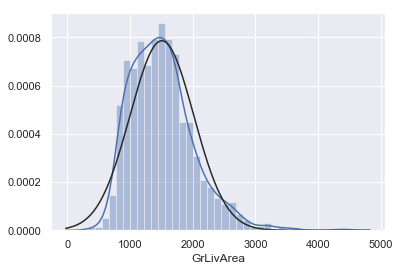

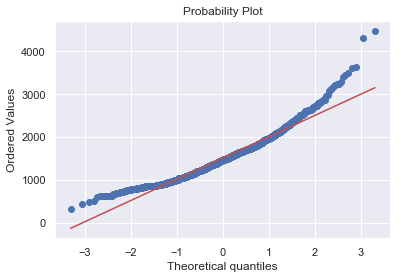

In [631]:
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

This looks like it has similar issues as SalePrice. Hopefully a log transformation will work again

In [632]:
train['GrLivArea'] = np.log(train['GrLivArea'])

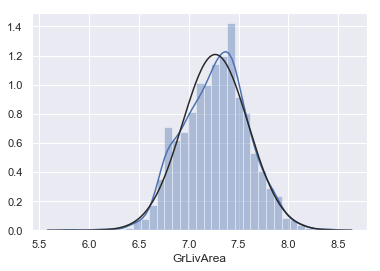

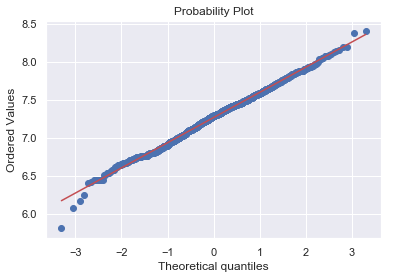

In [633]:
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

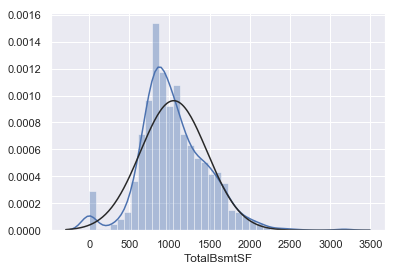

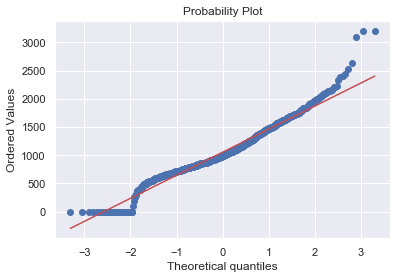

In [634]:
sns.distplot(train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

Wow so this looks pretty weird because of all of those 0 values. It might be best to make a dummy of whether the house has a basement or not and then use the non-zero data as quant data for the model. Alternatively we could just add one to every observation to be able to take the log but that difference between 0 square feet and 1 square foot is massive, and that method wouldn't account for that very well.

In [635]:
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBsmt'] = 0 
train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [636]:
train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

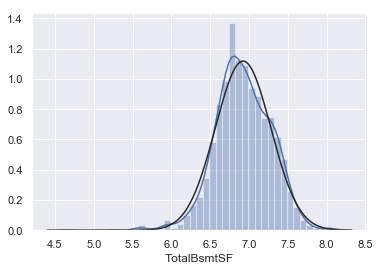

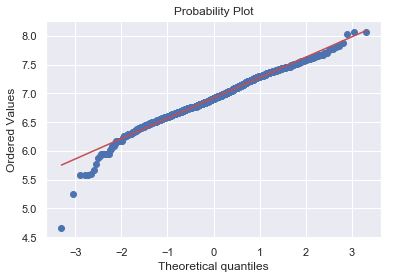

In [637]:
sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

That looks much much better! Now lets take advantage of all of the dummy variables we have!

In [638]:
train = pd.get_dummies(train)

We need to take out some columns that don't seem to be found in the test set due to unknown reasons.

In [639]:
cols = ['Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'Heating_Floor',
 'Heating_OthW',
 'HouseStyle_2.5Fin',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'SalePrice',
 'Utilities_NoSeWa']
x_train = train.drop(cols, axis=1)
y_train = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis])



linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(x_train, y_train)
predictions = linear_regression_model.predict(x_train)
mse = mean_squared_error(y_train, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 9122707845826426.0


This is really good! Its probably not ready to submit to Kaggle but since we have high variance according to the oracle lets try adding regularization to see if that helps.

In [640]:
from sklearn.linear_model import ElasticNetCV
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
clf.fit(x_train, y_train)
train_predictions = clf.predict(x_train)
test_predictions = clf.predict(x_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Train MSE: 0.09068542213271016
Test MSE: 0.11681932708860346


This RSME error is really solid considering the oracle value that is given on Kaggle. I would feel comfortable using it to predict hous prices since only predict poorly less than 1% of the time.This method helped the model eliminate the number of features being used so we can get rid of features that don't predict well. It looks a lot better and we are ready to submit to Kaggle and see how we do. Most likely we are not overfitting or underfitting with this model.

In [641]:
# def var_trans(df):
#     df = df.dropna()
#     df['GrLivArea'] = np.log(df['GrLivArea'])
#     df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
#     df['HasBsmt'] = 0 
#     df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1
#     df = pd.get_dummies(df)
#     return df

For some reason this function isn't working so I will just manually edit testdata.

In [642]:
df = testdata = pd.read_csv('test.csv')

In [643]:
df = df.drop((missing_data[missing_data['Total'] >= 1]).index, 1)
df['GrLivArea'] = np.log(df['GrLivArea'])
df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
df['HasBsmt'] = 0 
df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1
df = pd.get_dummies(df)
df = df.fillna(df.mean()) 
df.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,11622,5,6,1961,1961,468.0,144.0,270.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,14267,6,6,1958,1958,923.0,0.0,406.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,13830,5,5,1997,1998,791.0,0.0,137.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,9978,6,6,1998,1998,602.0,0.0,324.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,5005,8,5,1992,1992,263.0,0.0,1017.0,...,0,0,0,1,0,0,0,0,1,0


In [644]:
trans_testdata = df #pd.DataFrame(trans_testdata, columns = x_train.columns)
test_predictions = clf.predict(trans_testdata)
test_predictions

array([-0.65898836, -1.38824166,  0.21912094, ...,  0.14528141,
       -0.92367052,  0.87203368])

Now we need to unscale our predictions so we can get it checked on Kaggle

In [645]:
final_predictions = (test_predictions * std_of_array) + mean_of_array
len(final_predictions)
final_predictions

array([128569.51145211,  70635.80346362, 198328.71187776, ...,
       192462.71495397, 107542.49832792, 250197.7343477 ])

In [646]:
submission = pd.DataFrame({'Id':trans_testdata.Id, 'SalePrice':final_predictions})
submission.reset_index(drop=True, inplace=True)
submission.head()
submission.to_csv("3PricePredictions.csv", index_label=False)

It would also be fun to see how a KNN Regressor would work in this situation since it is much simpler. Spoiler Alert!!
Its awful. There are some errors that are happening now but when I orginally ran it my RSME was in the millions then in the hundres thousands then the ten thousands and then it didn't get any better after that.

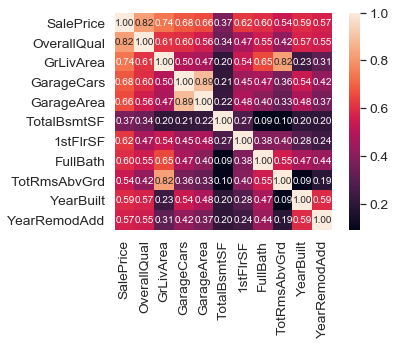

In [647]:
#This will pull the ten most correlated features with Sale Price and calculate the correlation between just those and SalePrice.
k = 11
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

This captures everything with a correlation of .5 or higher which will hopefully be plenty to make a decent model. We still need to deal with missing data, and find out the type of relationship that these variables have with `SalePrice`, but we'll get there.

In [648]:
columns = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']
train.drop(columns, axis=1, inplace=True)
train.describe()

KeyError: "['MSZoning' 'LotFrontage' 'Street' 'Alley' 'LotShape' 'LandContour'\n 'Utilities' 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1'\n 'Condition2' 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'\n 'Exterior2nd' 'MasVnrType' 'MasVnrArea' 'ExterQual' 'ExterCond'\n 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'\n 'BsmtFinType2' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical'\n 'KitchenQual' 'Functional' 'FireplaceQu' 'GarageType' 'GarageYrBlt'\n 'GarageFinish' 'GarageQual' 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence'\n 'MiscFeature' 'SaleType' 'SaleCondition'] not found in axis"

It looks like no one is missing any observations and but there might still be null values.

In [ ]:
train.isnull().sum()

Well that seems almost to easy but we'll go with it. A good place to start will just be a KNN regression since it is so simple.

In [ ]:
y_train = train['SalePrice']
x_train = train.drop('SalePrice', axis=1)

One of the easiest models to try is a KNN because we don't need to give it much info for it to go to work. This will be a good place to start for running my first model of this assignment.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=3)
reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(x_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(x_train)
y_pred_test = gridsearch.predict(x_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

That was a great first shot! But it went horribly wrong. Our MSE is super bad on both sets and we are definitely overfitting to our training data. Looks like we have more work to do. We should probably try to simplify our model which we can easily do by dropping out some of those features that aren't so predictive based on our heatmap. Let's give it a shot.

In [ ]:
k = 7
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Let's just include the variables that have a correlation of .6 or higher and see how that works.

In [ ]:
columns = ['YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'FullBath']
train.drop(columns, axis=1)
x_train = train
y_train = train['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=3)
reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(x_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(x_train)
y_pred_test = gridsearch.predict(x_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

This simplified model did much better than the previous one like 100X better but we still have a mega overfitting problem. Dare we simplfy it again to see if that helps. Lets raise the correlation threshold up again.

In [ ]:
k = 5
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
columns = ['TotalBsmtSF', '1stFlrSF']
x_train = train.drop(columns, axis=1)
y_train = train['SalePrice']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=3)
reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(x_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(x_train)
y_pred_test = gridsearch.predict(x_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

In [ ]:
columns = ['GarageCars']
x_train = train.drop(columns, axis=1)
y_train = train['SalePrice']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=3)
reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(x_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(x_train)
y_pred_test = gridsearch.predict(x_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

So reducing the number of features has made the model worse. Yikes. Since I don't know how use regularization I will move on to using Linear Regression. We can start with the same 10 features and work our way down from their.

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy import stats

We need to scale our data!

In [ ]:
x_train = train.drop('SalePrice', axis=1)
scaler = StandardScaler()
scaler.fit(x_train)
scaled_train = scaler.transform(x_train)
scaled_train.shape

In [ ]:
cols = [ 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
        '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice']
y_train = train['SalePrice']


linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(x_train, y_train)
predictions = linear_regression_model.predict(x_train)
mse = mean_squared_error(y_train, predictions)
print("RMSE: {}".format(np.sqrt(mse)))
predictions

Wow! That is significantly better than what our KNN model was producing. Way to go LR! Its still pretty high so we might need to add more features or change our model type to help us out. Lets try to add Polynomial features to improve it

In [ ]:
#scale test_set, keep columns
cols = [ 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
        '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']
test_set = testdata.filter([ 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
        '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea'], axis=1)
test_set.isnull().sum()

Lets try adding in those more complex polynomial relationship!

In [ ]:
poly = PolynomialFeatures(2, include_bias=False)
poly_df = poly.fit_transform(x_train)
scaled_poly_df = scaler.fit_transform(poly_df)
print(scaled_poly_df.shape)

In [ ]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(x_train, y_train)

predictions = linear_regression_model.predict(x_train)
mse = mean_squared_error(y_train, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

So they are so few missing values that I feel comfortable just dropping them

In [ ]:
test_set.dropna(inplace=True)
test_set.isnull().sum()

In [ ]:
scaled_test = scaler.transform(test_set)

In [ ]:
test_predictions = linear_regression_model.predict(scaled_test)
test_predictions

Something that might help us reduce our RMSE is allowing the LR model to learn more complex relationships that aren't linear. Lets see if any of these types of relationships exist.